In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns

import sys
sys.path.append("../../../../../src")

import nanonets_utils

from scipy import signal
from sklearn.decomposition import PCA

plt.style.use(["science","bright"])

def load_time_series(path, N_threads, samples_per_thread, N_p, skip_eq=0):
    n   = 0
    dic = {}
    for i in range(N_threads):
        for j in range(samples_per_thread):
            df      =   pd.read_csv(f"{path}Nx={N_p}_Ny={N_p}_Nz=1_Ne=8_{i}_{j}.csv")
            dic[n]  =   df.iloc[skip_eq:,:]
            n       +=  1
    return dic

def load_states(path, N_threads, samples_per_thread, N_p, skip_eq=0):
    n   = 0
    dic = {}
    for i in range(N_threads):
        for j in range(samples_per_thread):
            df      =   pd.read_csv(f"{path}mean_state_Nx={N_p}_Ny={N_p}_Nz=1_Ne=8_{i}_{j}.csv")
            dic[n]  =   df.iloc[skip_eq:,:]
            n       +=  1
    return dic

def return_best_fit(y_real_arr, y_target):
    y_target    = nanonets_utils.standard_norm(y_target)
    rmse        = []

    for i in range(y_real_arr.shape[1]):
        y_real  = y_real_arr[:,i].copy()
        y_real  = nanonets_utils.standard_norm(y_real)
        rmse.append(np.sqrt(np.sum((y_real-y_target)**2)))

    return np.argsort(rmse), rmse 

In [39]:
param   = "const"
N_th    = 36
n_p_t   = 1
N_p     = 11
t_step  = 1e-7
skip_eq = 8000
# folder  = f"/home/j/j_mens07/phd/data/2_funding_period/potential/magic_cable/sine/{param}/"
folder  = f"/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/potential/magic_cable/sine/{param}/"
data    = load_time_series(folder, N_th, n_p_t, N_p, skip_eq)
# states  = load_states(folder, N_th, n_p_t, N_p)
t_vals  = np.arange(len(data[0]))*1e-7*1e6

## Sample: Output vs Time / Output vs Input

Text(0, 0.5, '$U_7$ [$mV$]')

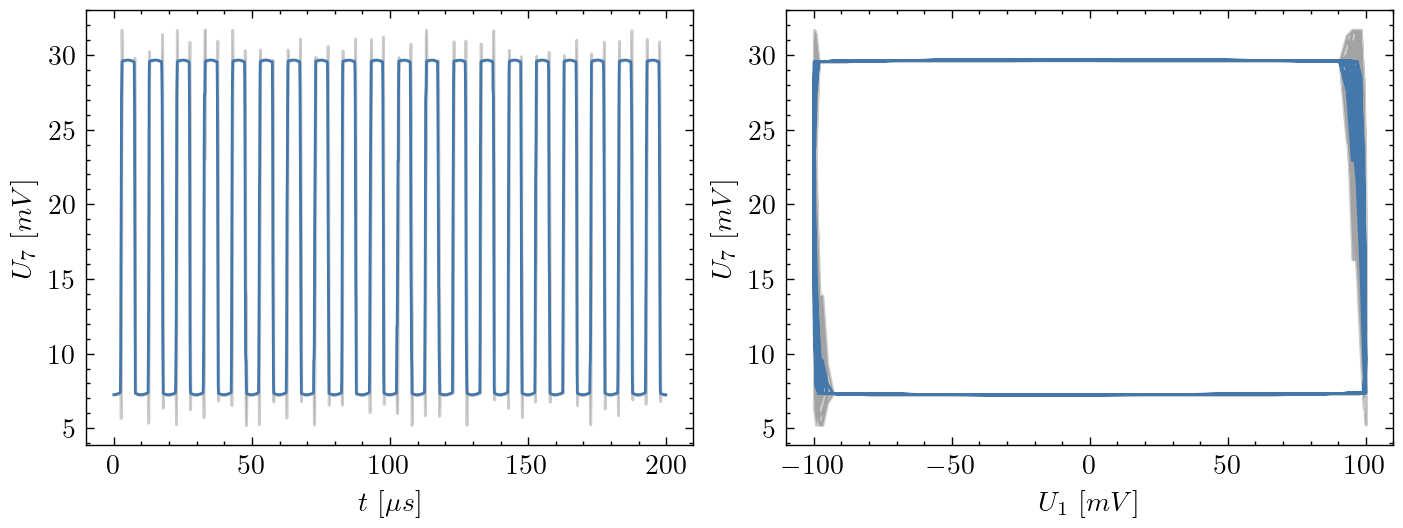

In [84]:
idx     = 6
x_val   = data[idx]['E0'].values*1000
val     = data[idx]['Current'].values*1000
val_e   = data[idx]['Error'].values*1000

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot(1,2,1)
ax.plot(t_vals, val)
ax.fill_between(t_vals, val-val_e, val+val_e, color='black', alpha=0.2)
ax.set_xlabel('$t$ [$\mu s$]')
ax.set_ylabel('$U_7$ [$mV$]')

ax  = fig.add_subplot(1,2,2)
ax.plot(x_val, val)
ax.fill_between(x_val, val-val_e, val+val_e, color='black', alpha=0.2)
ax.set_xlabel('$U_1$ [$mV$]')
ax.set_ylabel('$U_7$ [$mV$]')

## Shannon Rank

In [14]:
outputs     = np.array([df['Current'].values for _, df in data.items()]).T
output_rank = nanonets_utils.shannon_rank(outputs)
ranks       = [nanonets_utils.shannon_rank(state.values) for _, state in states.items()]

In [24]:
np.savetxt(f"data/ranks_{param}.csv", ranks)

Text(0.5, 0, '$\\sum_i p_i \\cdot log(p_i)$')

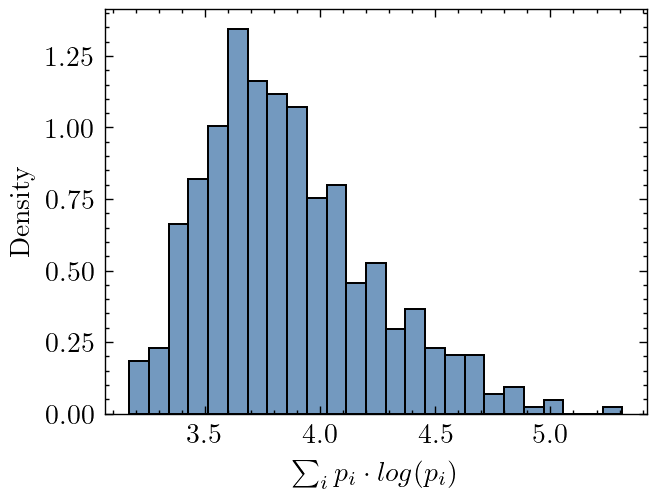

In [29]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.histplot(ranks, ax=ax, bins=25, stat='density')
ax.set_xlabel("$\sum_i p_i \cdot log(p_i)$")

## Train

In [334]:
y_target        = 10*signal.square(2*np.pi*t_vals*0.1)
# y_target        = 10*signal.sawtooth(2*np.pi*t_vals*0.1)
# y_target        = 10*signal.sawtooth(2*np.pi*t_vals*0.1, 0.5)
fit_order, rmse = return_best_fit(y_real_arr=arr1, y_target=y_target)
best_idx        = fit_order[1]

Text(0.5, 0, '$t$ [$\\mu s$]')

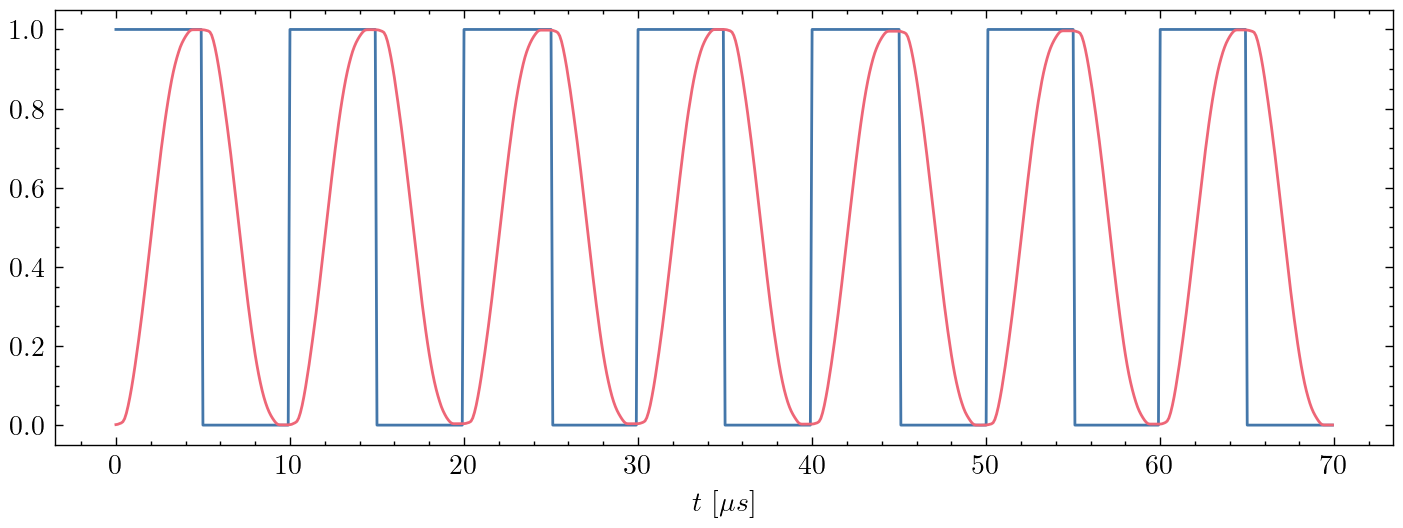

In [335]:
y_1 = scale(y_target)
y_2 = scale(arr1[:,best_idx])

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)

ax  = fig.add_subplot()
ax.plot(t_vals, y_1)
ax.plot(t_vals, y_2)
ax.set_xlabel('$t$ [$\mu s$]')